# (WI4650) CodeLab 7 - QML
### Problem: QML for ordinary differential equations

In this Codelab you will learn how to implement a QML for the ordinary differential equation (ODE) $\frac{df}{dx}=4x^3+x^2-2x-\frac122$ with $f(0)=1$ using Qadence.

To get started, please do the following:
1. Install [Qadence](https://pasqal-io.github.io/qadence/latest/) and some additional Python packages: `pip install jupyterlab qadence`
2. Start JubyterLab: `jupyter lab`

### A working QML example

Qadence is yet another quantum programming package that is particularly useful for developing QML applications.

In [25]:
# General imports
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform
from qadence import *
import torch
from torch import nn, optim, tensor, zeros_like, ones_like, linspace, manual_seed
from torch.autograd import grad

Let us define some global parameters. You can later change these parameters to study how less or more qubits or a deeper quantum network influences the QML's performance.

In [13]:
manual_seed(404) #  random seed
N_QUBITS, DEPTH, LEARNING_RATE, N_POINTS = 6, 5, 0.01, 20 #4, 3, 0.01, 20

An essential part of a QML is the **ansatz**, that is, a parametric circuit whose parameters will be trained. 
Let us use the **hardware-efficient ansatz** (`hea`)

In [14]:
ansatz = hea(n_qubits=N_QUBITS, depth=DEPTH)

The other important part is the **feature map**, which encodes the input of our quantum network into the quantum circuit. Here, we use the **Chebyshev feature map**

In [15]:
fm = feature_map(n_qubits=N_QUBITS, param="x", fm_type = BasisSet.CHEBYSHEV)

Next, we need to define a **cost function**. Don't confuse this with the loss function that encodes our ODE. Let us choose the **transverse-field Ising Hamiltonian**

In [16]:
obs = ising_hamiltonian(n_qubits=N_QUBITS)

Now we are ready to build the *quantum circuit* and the **QNN model**

In [19]:
circuit = QuantumCircuit(N_QUBITS, chain(fm, ansatz))
model = QNN(circuit=circuit, observable=obs, inputs=["x"])

Let us turn to the classical part of the QNN. First, we need to choose an **optimizer**. Here, we use Adam

In [20]:
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Next, we need to implement the **loss function**. In our case, we implement the MSE loss function for the ODE $\frac{df}{dx}=4x^3+x^2-2x-1/2$ with $f(0)=1$

In [26]:
def loss_fn(inputs: tensor, outputs: tensor) -> tensor:
    dfdx = grad(inputs=inputs, outputs=outputs.sum(), create_graph=True)[0]
    ode_loss = dfdx + 8*outputs*(0.1+torch.tan(8*inputs)) - 0  #dfdx - (4 * inputs**3 + inputs**2 - 2 * inputs - 0.5)
    boundary_loss = model(zeros_like(inputs)) - ones_like(inputs)
    return ode_loss.pow(2).mean() + boundary_loss.pow(2).mean() 

Let us train the QNN for 1000 epochs with randomly samples collocation points between (-1.0, 1.0)

In [28]:
for epoch in range(1000):
    opt.zero_grad()

    # the collocation points are sampled randomly
    cp = tensor(
        uniform(low=0, high=0.9, size=(N_POINTS, 1)), requires_grad=True
    ).float()
    
    loss = loss_fn(inputs=cp, outputs=model(cp))
    
    if (epoch % 50 == 0):
        print(epoch, loss.item())
        
    loss.backward()
    opt.step()

0 78.05384639864488
50 26.785709140472274
100 40218075.13620537
150 5.725987681769591
200 35.972301802163464
250 5.537385876188349
300 6.828145458967664
350 429.75462976300804
400 1657.3977980594998
450 21998.00338965503
500 535.486402410178
550 1960.2575017755478
600 2394.6170911693202
650 1008.8991273579292
700 4797.49923938415
750 2882.825065769709
800 12.273454160388969
850 249.53950690266288
900 9.236915780755073
950 199.99770265325319


To compare the quality of the learned solution, we also create the analytic one

In [34]:
sample_points = linspace(0.0, 0.9, steps=100).reshape(-1, 1)
analytic_sol = torch.exp(-0.1*8*sample_points)*torch.cos(8*sample_points) + 1
    
'''
(sample_points**4
+ (1 / 3) * sample_points**3
- sample_points**2
- (1 / 2) * sample_points
+ 1)
'''

'\n(sample_points**4\n+ (1 / 3) * sample_points**3\n- sample_points**2\n- (1 / 2) * sample_points\n+ 1)\n'

Now, let us evaluate the solution predicted by the QNN

In [35]:
dqc_sol = model(sample_points).detach().numpy()
x_data = sample_points.detach().numpy()

As a last step, let's have a look at the two solutions

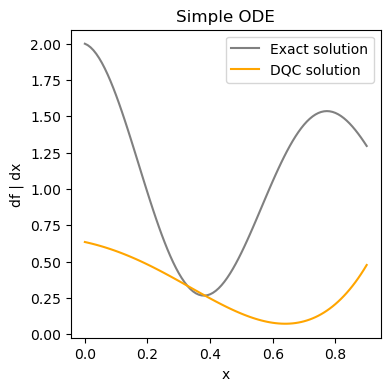

In [36]:
plt.figure(figsize=(4, 4))
plt.plot(x_data, analytic_sol.flatten(), color="gray", label="Exact solution")
plt.plot(x_data, dqc_sol.flatten(), color="orange", label="DQC solution")
plt.xlabel("x")
plt.ylabel("df | dx")
plt.title("Simple ODE")
plt.legend()
plt.show()

### Part A)

Now it's your turn to explore the influence of the different parts on the QNN's performance.

**A1)** Increase/decrease the number of qubits (`N_QUBITS`) and leave all other parameters unchanged. Does this change the performance of the QNN?

**A2)** Increase/decrease the depth of the ansatz (`DEPTH`) and leave all other parameters unchanged. Does this change the performance of the QNN?

**A3)** Try the Fourier feature maps (`BasisSet.FOURIER`) as an alternative to the Chebyshev one. Does this change the performance of the QNN?

**A4)** Try one of the other optimizers, e.g., `optim.LBFGS`, `optim.RMSprop`, or `optim.SGD`. Does this change speed of the training process?

### Part B)

In this part, you will implement a QNN for a different ODE, namely, $\frac{df}{dy}=\cos(x)$ with $y(0)=0$